# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [3]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [4]:
#Drop the response variable
data_train_01=data_train.copy().drop(['Cancer_type'], axis=1)

In [5]:
y_train=data_train['Cancer_type']

In [6]:
data_train_01.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
5,-67,-93,84,25,-179,-323,-135,-127,-2,-66,...,48,224,60,194,-10,291,41,8,-2,-80
9,-476,-213,-18,301,-403,-394,-42,-144,98,173,...,241,1214,127,255,50,1701,1108,61,525,-83
10,-81,-150,-119,78,-152,-340,-36,-141,96,-55,...,186,573,-57,694,-19,636,205,17,127,-13


In [7]:
#Normalize the training data, and store them in the dataframe.
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
x_train_scaled=scaler.fit_transform(data_train_01)
data_train_norm=pd.DataFrame(x_train_scaled, columns = data_train_01.columns)

In [8]:
data_train_norm.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.466192,0.739726,0.255814,0.246154,0.433190,0.240418,0.880427,0.625850,0.928074,0.696281,...,0.385445,0.268542,0.398126,0.161897,0.677778,0.323241,0.322609,0.751381,0.069457,0.381720
1,0.658363,0.794521,0.213953,0.421978,0.573276,0.717770,0.741637,0.748299,0.505800,0.743802,...,0.307278,0.356777,0.824356,0.206978,0.718519,0.081478,0.309565,0.629834,0.027597,0.446237
2,0.727758,0.857143,0.586047,0.107692,0.683190,0.649826,0.642705,0.736961,0.338747,0.415289,...,0.016173,0.085038,0.831382,0.085457,0.777778,0.099733,0.072174,0.596685,0.009612,0.150538
3,0.000000,0.622309,0.348837,0.714286,0.200431,0.526132,0.708897,0.698413,0.570766,0.662190,...,0.536388,0.718031,0.988290,0.109369,1.000000,0.727516,1.000000,0.889503,0.173023,0.134409
4,0.702847,0.745597,0.113953,0.224176,0.741379,0.620209,0.713167,0.705215,0.566125,0.426653,...,0.388140,0.308184,0.557377,0.281458,0.744444,0.253339,0.214783,0.646409,0.049612,0.510753


In [9]:
#Drop the response variable
data_test_01=data_test.copy().drop(['Cancer_type'], axis=1)

In [10]:
y_test=data_test['Cancer_type']

In [11]:
#Normalize the test data
x_test_scaled=scaler.fit_transform(data_test_01)
data_test_norm=pd.DataFrame(x_test_scaled, columns = data_test_01.columns)

In [12]:
data_test_norm.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.649533,0.764569,0.934903,0.111111,0.186260,0.339879,0.479698,0.478360,0.392216,0.225069,...,0.719807,0.533835,1.000000,0.083593,0.190,0.271877,0.188534,0.487578,0.074961,0.430435
1,0.796729,0.694639,0.897507,0.210648,0.216794,0.391239,0.454202,0.646925,0.622754,0.178408,...,0.212560,0.521805,0.017370,0.071651,0.650,0.554210,0.532525,0.673913,0.168856,0.643478
2,0.000000,0.424242,0.577562,0.078704,0.000000,0.030211,0.070822,0.000000,0.455090,0.042086,...,0.838164,0.378947,0.245658,0.150052,0.855,0.916346,0.492834,0.826087,0.328053,0.913043
3,0.750000,0.752914,0.524931,0.483796,0.470229,0.880665,0.284230,0.913440,0.284431,0.407136,...,0.654589,0.344361,0.466501,0.268432,0.545,0.309851,0.334068,0.717391,0.054869,0.778261
4,0.714953,0.862471,0.393352,0.428241,0.512977,0.794562,0.173749,0.633257,0.248503,0.175663,...,0.429952,0.448872,0.508685,0.165628,0.715,0.034122,0.066152,0.739130,0.071097,0.747826


**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


----
Your answer here:

**The model will be very likely overfitted.**

----

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

In [13]:
#Put the column name into an accepted way
data_train_norm.rename(columns={'AFFX-PheX-5_at': 'AFFX_PheX_5_at'}, inplace=True)

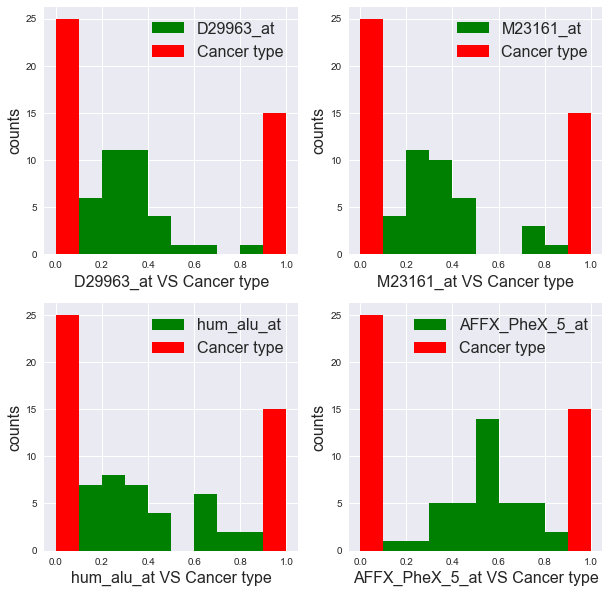

In [14]:
# your code here
fig, axes=plt.subplots(2,2, figsize=(10,10))
axes[0,0].hist(data_train_norm.D29963_at, color='g', label='D29963_at');
axes[0,0].hist(y_train, color='r', label='Cancer type');
axes[0,0].set_xlabel('D29963_at VS Cancer type', fontsize=16);
axes[0,0].set_ylabel('counts', fontsize=16);
axes[0,0].legend(fontsize=16);

axes[0,1].hist(data_train_norm.M23161_at, color='g', label='M23161_at');
axes[0,1].hist(y_train, color='r', label='Cancer type');
axes[0,1].set_xlabel('M23161_at VS Cancer type', fontsize=16);
axes[0,1].set_ylabel('counts', fontsize=16);
axes[0,1].legend(fontsize=16);

axes[1,0].hist(data_train_norm.hum_alu_at, color='g', label='hum_alu_at');
axes[1,0].hist(y_train, color='r', label='Cancer type');
axes[1,0].set_xlabel('hum_alu_at VS Cancer type', fontsize=16);
axes[1,0].set_ylabel('counts', fontsize=16);
axes[1,0].legend(fontsize=16);

axes[1,1].hist(data_train_norm.AFFX_PheX_5_at, color='g', label='AFFX_PheX_5_at');
axes[1,1].hist(y_train, color='r', label='Cancer type');
axes[1,1].set_xlabel('AFFX_PheX_5_at VS Cancer type', fontsize=16);
axes[1,1].set_ylabel('counts', fontsize=16);
axes[1,1].legend(fontsize=16);

----
Your answer here:

**D29963_at, M23161_at, hum_alu_at seem to be different in two cancer types, and AFFX_PheX_5_at doesn't. The histograms of the first three genes, the gene expression levels have two groups, but the AFFX_PheX_5_at shows bell shape, meaning no specific relationship on cancer types.**

----

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

In [15]:
# your code here
from sklearn.preprocessing import StandardScaler
# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(data_train_norm)
x_train_scaled = scale_transformer.transform(data_train_norm)
x_test_scaled = scale_transformer.transform(data_test_norm)


# reduce dimensions
pca_transformer = PCA(2).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

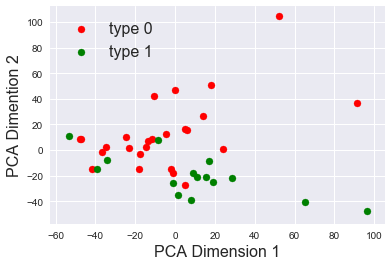

In [16]:
colors = ['r','g']
label_text=['type 0', 'type 1']
# and we loop over the different groups
for cancer_type in [0,1]:
    can_tp = x_train_2d[y_train==cancer_type]
    plt.scatter(can_tp[:,0], can_tp[:,1], c = colors[cancer_type], label=label_text[cancer_type])
    
# all plots need labels
plt.xlabel("PCA Dimension 1", fontsize=16)
plt.ylabel("PCA Dimention 2", fontsize=16)
plt.legend(fontsize=16);

In [17]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained: {:.4f}".format(np.sum(var_explained)))

Variance explained by each PCA component: [0.15642787 0.11389365]
Total Variance Explained: 0.2703


----
Your answer here:

**The top two PCA could only partially discriminate between two classes. This two PCA explained around 27% of the variances of the train data. The first PCA component explained 15.6% and the second 11.4%.** 

----

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [18]:
# your code here
from sklearn.linear_model import LinearRegression
X_train=data_train_norm.copy()
X_train_D=X_train['D29963_at'].values.reshape(-1,1)
X_Dmodel = LinearRegression().fit(X_train_D,y_train)

In [19]:
y_pre_D=X_Dmodel.predict(X_train_D)

Text(0,0.5,'y_hat')

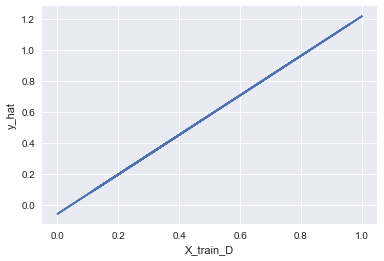

In [20]:
plt.plot(X_train_D, y_pre_D)
plt.xlabel('X_train_D')
plt.ylabel('y_hat')

In [21]:
X_Dmodel.coef_

array([1.27643062])

----
Your answer here:

**Because the predicted y and x has linear relationship, it's very difficult to tell when will Cancer_type =1, or 0.**

----


**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [22]:
#Classify the predicted output on training data
# your code here
y_newtrain_pre=np.zeros(len(y_pre_D))
for i, val in enumerate(y_pre_D):
    if val>0.5:
        y_newtrain_pre[i]=1

In [23]:
#Evaluate classification accuracy on training data
print('The classification accuracy of linear regression model is:{:.4f}'.format(np.sum(y_train == y_newtrain_pre) / len(y_train)))

The classification accuracy of linear regression model is:0.8000


In [24]:
#Predict the cancer type on test data
X_test=data_test_norm.copy()
X_test_D=X_test['D29963_at'].values.reshape(-1,1)
y_pretest_D=X_Dmodel.predict(X_test_D)

In [25]:
#Classify the predicted output on test data
y_newtest_pre=np.zeros(len(y_pretest_D))
for i, val in enumerate(y_pretest_D):
    if val>0.5:
        y_newtest_pre[i]=1

In [26]:
#Evaluate classification accuracy on test data
print('The classification accuracy of linear regression model on test data is:{:.4f}'.format(np.sum(y_test == y_newtest_pre) / len(y_test)))

The classification accuracy of linear regression model on test data is:0.7879


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [27]:
# Fit training data using logistic regression model
train_fitted_logit = LogisticRegression(C=100000).fit(X_train_D,y_train)

In [28]:
#Calculate the classivication accuracy of training data
train_binary_prediction = train_fitted_logit.predict(X_train_D) >= .5
print('The classification accuracy of binary logistic model is:{:.4f}'.format(np.sum(y_train == train_binary_prediction) / len(y_train)))

The classification accuracy of binary logistic model is:0.8000


In [29]:
#Calculate the classivication accuracy of test data
test_binary_prediction = train_fitted_logit.predict(X_test_D) >= .5
print('The classification accuracy of binary logistic model on test data is:{:.4f}'.format(np.sum(y_test == test_binary_prediction) / len(y_test)))

The classification accuracy of binary logistic model on test data is:0.6970


----
Your answer here:

**The training classification in this model equals to linear regression model. But the test classification accuracy is smaller than linear regression model.**

----


**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

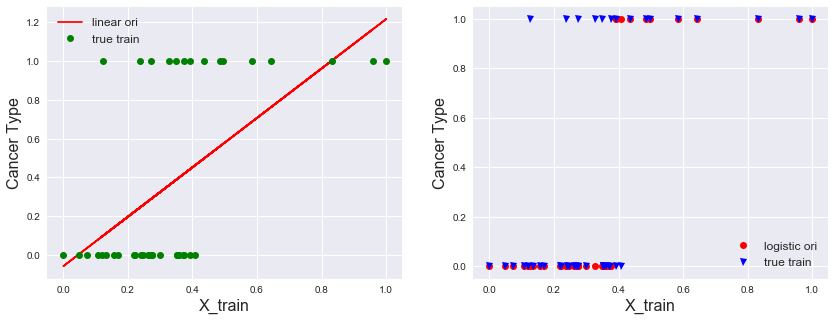

In [30]:
# your code here
fig, axes=plt.subplots(1,2, figsize=(14, 5))
axes[0].plot(X_train_D, y_pre_D, color='r', label='linear ori');
axes[0].plot(X_train_D, y_train, 'o', color='g', label='true train');
axes[0].set_xlabel('X_train', fontsize=16);
axes[0].set_ylabel('Cancer Type', fontsize=16);
axes[0].legend(fontsize=12);

axes[1].plot(X_train_D, train_binary_prediction,'o', color='r', label='logistic ori');
axes[1].plot(X_train_D, y_train, 'v', color='b', label='true train');
axes[1].set_xlabel('X_train', fontsize=16);
axes[1].set_ylabel('Cancer Type', fontsize=16);
axes[1].legend(fontsize=12);

----
Your answer here

----

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [31]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [32]:
# your code here
multi_logist=LogisticRegression(C=1000000, solver='newton-cg', max_iter=250).fit(X_train,y_train)

In [33]:
#Calculate the classification accuracy on training data
train_multi_prediction = multi_logist.predict(X_train) >= .5
print("The classification accuracy of test data is: {:.4f}".format(np.sum(y_train == train_multi_prediction) / len(y_train)))

The classification accuracy of test data is: 1.0000


In [34]:
#Calculate the classification accuracy on test data
test_multi_prediction = multi_logist.predict(X_test) >= .5
print("The classification accuracy of test data is: {:.4f}".format(np.sum(y_test == test_multi_prediction) / len(y_test)))

The classification accuracy of test data is: 0.9697


----
Your answer here:

**The accuracies on both training and test sets by using this model were increased to 1.0 and 0.970, respectively.**

----

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

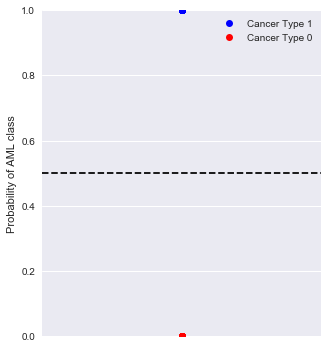

In [35]:
# your code here
fig,ax=plt.subplots(figsize=(5, 6))
visualize_prob(multi_logist, X_train, y_train, ax)

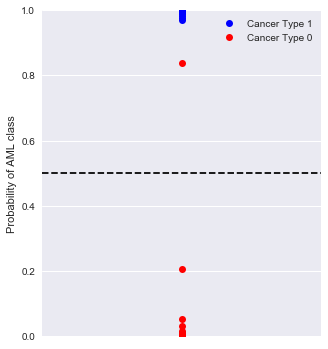

In [36]:
fig,ax=plt.subplots(figsize=(5, 6))
visualize_prob(multi_logist, X_test, y_test, ax)

----
Your answer here:

**In training data, the positive possiblility points overlap to 1, and the negative points overlap to 0. While in test data, the points spread from 0 to 1. None of the predicted points are close to 0.5.**

----

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [37]:
# dataset_x should be a pandas dataframe

## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # your code here
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    
    sample_indices = np.random.choice(len(dataset_X), size=size, replace=True)
    
    bootstrap_dataset_X = dataset_X.iloc[sample_indices]
    bootstrap_dataset_y = dataset_y[sample_indices]
    
    # return as a tuple your bootstrap samples of dataset_X as a pandas dataframe
    # and your bootstrap samples of dataset y as a numpy column vector
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    # your code here
    
    # fit the model
    model.fit(dataset_X, dataset_y) 
    
    coefficients_dictionary = {k:v for k, v in zip(dataset_X.columns, model.coef_.ravel())}
    
    # return coefficients  in the variable  coefficients_dictioanry as a dictionary
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # do not return the intercept as part of this
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    
    # your code here

    
    # regression_coefficients is a list of dictionaries
    # with the key being the name of the feature as a string
    # the value being the value of the coefficients
    # each dictionary in th list should be the output of calculate_coefficients
    
    if (len(regression_coefficients) <= 0):
        return []
    
    coeff_names = np.array(list(regression_coefficients[0].keys()), dtype='object')
    coeff_samples = [list(coeff_list.values()) for coeff_list in regression_coefficients]
    
    coeff_samples = np.array(coeff_samples)
        
    # Obtain bottom percentile values
    bottom_percentile = np.percentile(coeff_samples, q=100*significance_level/2, axis=0)
    
    # Obtain top percentile values
    top_percentile = np.percentile(coeff_samples, q=100*(1-significance_level/2), axis=0)
    
    # Coefficients with bottom value greater than 0 or top value less than 0 are signficant
    significant_index = ((bottom_percentile > 0.0) | (top_percentile < 0.0))
 
    significant_coefficients = list(coeff_names[significant_index])
      
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [38]:
#Prepare the matrix and response variable
y_train=y_train.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)

In [39]:
# generate significant predictors
regression_coefficients = []
for i in range(1000):
    sample_X, sample_y = make_bootstrap_sample(X_train, y_train, size = None)
    coefficient_dict = calculate_coefficients(sample_X, sample_y, LogisticRegression(C=100000, solver='newton-cg', max_iter=250))
    regression_coefficients.append(coefficient_dict)
    
Significant_bootstrap = get_significant_predictors(regression_coefficients, 0.05)

In [40]:
print('The significant predictors from bootstrap are: {0}'.format(Significant_bootstrap))

The significant predictors from bootstrap are: ['AFFX-BioC-3_at', 'AFFX-BioB-3_st', 'hum_alu_at', 'AFFX-DapX-5_at', 'AFFX-LysX-3_at', 'AFFX_PheX_5_at', 'AFFX-HUMISGF3A/M97935_MA_at', 'AFFX-HUMRGE/M10098_5_at', 'AFFX-HUMRGE/M10098_M_at', 'AFFX-HUMRGE/M10098_3_at', 'AFFX-M27830_5_at', 'AFFX-M27830_M_at', 'AB000449_at', 'AB000466_at', 'AB000895_at', 'AB001325_at', 'AB002559_at', 'AB003698_at', 'AB004884_at', 'AC000062_at', 'AC000064_cds1_at', 'AC002115_cds3_at', 'AF001294_at', 'AF002700_at', 'AF005043_at', 'AF006084_at', 'AF009301_at', 'AF009426_at', 'AF010193_at', 'AF014958_at', 'AF015913_at', 'AF015950_at', 'AJ000480_at', 'AJ001421_at', 'D00017_at', 'D00726_at', 'D00760_at', 'D10495_at', 'D11086_at', 'D12625_at', 'D13118_at', 'D13315_at', 'D13628_at', 'D13637_at', 'D13639_at', 'D13642_at', 'D13748_at', 'D13969_at', 'D14533_at', 'D14658_at', 'D14659_at', 'D14660_at', 'D14661_at', 'D14664_at', 'D14689_at', 'D14811_at', 'D14838_at', 'D15050_at', 'D16217_at', 'D16227_at', 'D16350_at', 'D164

## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [41]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

In [42]:
# your code here
x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,12, 15, 18, 20,25, 30]
ratio=[]
for d in x:
    ratio.append(V_s(d)/V_c(d))

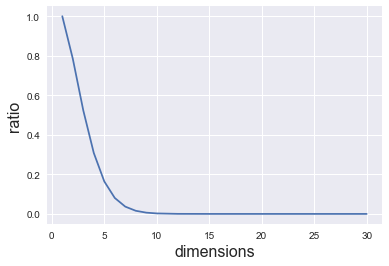

In [43]:
plt.plot(x, ratio);
plt.ylabel('ratio', fontsize=16);
plt.xlabel('dimensions', fontsize=16);

----
Your answer here:

**V_s(d)/V_c(d) of the volume of hypercube is resides in the hypersphere. When d increases, the ratio gets smaller and smaller and reaches to zero very fast. ** 

----

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [44]:
# your code here
data_x6=data_train_norm.copy()
# scale the datasets
scale_transformer6 = StandardScaler(copy=True).fit(data_x6)
x_train_scaled6 = scale_transformer6.transform(data_x6)
pca_ratio=0
d=1
while (pca_ratio<0.9): 
    d=d+1
    pca_transformer = PCA(d).fit(x_train_scaled6)
    pca_ratio=np.sum(pca_transformer.explained_variance_ratio_)
print('The number of principal components to capture 90% of the variance is : {0}'.format(d))

The number of principal components to capture 90% of the variance is : 29


In [45]:
print('The percentage of the variance captured is: {:.4f}'.format(np.sum(pca_transformer.explained_variance_ratio_)))

The percentage of the variance captured is: 0.9034


In [46]:
x_test6=data_test_norm.copy()

In [47]:
#Standardizae test data
x_test_scaled6 = scale_transformer.transform(x_test6)

In [48]:
#Apply the optimized pca model
pca_transformer6=PCA(29).fit(x_train_scaled6)

In [49]:
#Build matrices of training and test sets using pca components
x_train_pca = pca_transformer6.transform(x_train_scaled6)
x_test_pca =  pca_transformer6.transform(x_test_scaled6)

In [50]:
train_reg=LogisticRegression(C=100000, solver='newton-cg', max_iter=250).fit(x_train_pca, y_train)

In [51]:
#Calculate classification accuracy of training data
print("The classification accuracy of training data is: {:.4f}".format(np.sum(y_train == train_reg.predict(x_train_pca)) / len(y_train)))

The classification accuracy of training data is: 1.0000


In [52]:
#Calculate classification accuracy of test data
print("The classification accuracy of test data is: {:.4f}".format(np.sum(y_test==train_reg.predict(x_test_pca))/len(y_test)))

The classification accuracy of test data is: 0.7879


----
Your answer here:

**To caputure 90% variance, 29 principle components are needed. With 29 principle components, 90.3% of the variance was captured. Here, the classification accuracy of training data equals to the one from question 3.1; the classification accuracy of test data is smaller than the one from question 3.1.**

----

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

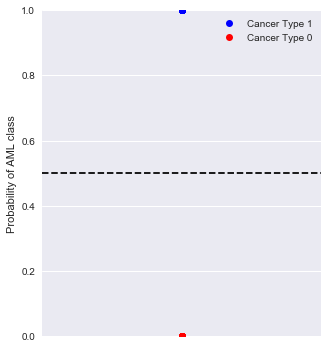

In [53]:
# your code here
fig,ax=plt.subplots(figsize=(5, 6))
visualize_prob(train_reg, x_train_pca, y_train, ax)

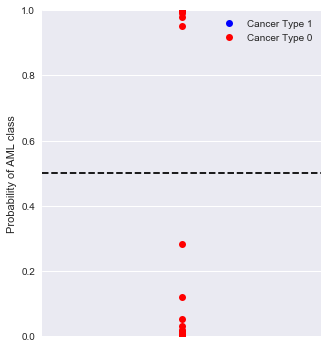

In [54]:
# your code here
fig,ax=plt.subplots(figsize=(5, 6))
visualize_prob(train_reg, x_test_pca, y_test, ax)

----
Your answer here: **The spread of the probabilities of the training data is same as the one in Q3.2. But the spread of test data is not as good as the one in Q3.2. The low dimension model normally will lose some fitting accuracy. But in this case, the model seems to be overfitted.**

----


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [55]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [56]:
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [57]:
#Generate x-matrix and response variable
data_train_x=data_train.drop(['Diagnosis'], axis=1).reset_index(drop=True)
data_train_y=data_train['Diagnosis'].reset_index(drop=True)

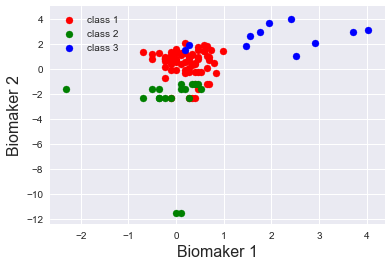

In [58]:
#Plot 2D scatter of training data
colors = ['r','g','b']
label_text = ["class 1", "class 2", "class 3"]

# and we loop over the different groups
for clas in [1,2,3]:
    data_df = data_train_x[data_train_y==clas]
    plt.scatter(data_df['Biomarker 1'], data_df['Biomarker 2'], c = colors[clas-1], label=label_text[clas-1])
    
# all plots need labels
plt.xlabel("Biomaker 1", fontsize=16)
plt.ylabel("Biomaker 2", fontsize=16)
plt.legend();


----
Your answer here:

**The classes could be separated well by a linear classifier.**

----

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
Your answer here:

**OvR basically fits multiple times using linear regression by grouping the classes into one and rest. Multinomial logistic regression takes care of every pair of classes in all the classes.**

----

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [59]:
from sklearn.model_selection import cross_val_score
#Set up test data matrix and response variable
data_test_x=data_test.drop(['Diagnosis'], axis=1).reset_index(drop=True)
data_test_y=data_test['Diagnosis'].reset_index(drop=True)

In [60]:
#Fit training data by linear logistic regression model by tuning L2 using CV
lcv=LogisticRegressionCV(Cs=[0.001, 0.1, 0.5, 1, 3, 10, 100, 1000], solver='newton-cg', max_iter=250).fit(data_train_x, data_train_y)
cross_val_score(lcv, data_train_x, data_train_y, cv=3)

array([0.8       , 0.85294118, 0.84848485])

In [61]:
#Fit training data by multinormial logistic regression model by tuning L2 using CV
lmv=LogisticRegressionCV(Cs=[0.001, 0.1, 0.5, 1, 3, 10, 100, 1000], multi_class='multinomial', solver='newton-cg', max_iter=250).fit(data_train_x, data_train_y)
cross_val_score(lmv, data_train_x, data_train_y, cv=3)

array([0.82857143, 0.88235294, 0.93939394])

In [62]:
#Calculate the classification accuracy of OVR model
y_ovr_predict=lcv.predict(data_test_x)
print("The classification accuracy of OVR model is: {:.4f}".format(np.sum(data_test_y == y_ovr_predict) / len(data_test_y)))

The classification accuracy of OVR model is: 0.8407


In [63]:
#Calculate the classification accuracy of multinomial logistic regression model
y_multi_predict=lmv.predict(data_test_x)
print("The classification accuracy of multinomial logistic model is: {:.4f}".format(np.sum(data_test_y == y_multi_predict) / len(data_test_y)))

The classification accuracy of multinomial logistic model is: 0.8850


----
Your answer here:

**As shown above, the multinomial logistic regression model performs better on the test data on the overall classification accuracy.**

----

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [64]:
#Add quadratic terms to training data
data_train_x_mul=data_train_x.copy()
poly=PolynomialFeatures(degree=2,  include_bias=False)
data_x_matr=poly.fit_transform(data_train_x_mul)

In [65]:
#Add quandratic terms to test data
data_test_x_mul=data_test_x.copy()
poly=PolynomialFeatures(degree=2,  include_bias=False)
data_x_matr_test=poly.fit_transform(data_test_x_mul)

In [66]:
#Multiclass Logistic Regression
multi_logist=LogisticRegressionCV(Cs=[0.001, 0.1, 0.5, 1, 3, 10, 100, 1000], solver='newton-cg', max_iter=250).fit(data_x_matr, data_train_y)
y_train7_pred=multi_logist.predict(data_x_matr)
#Classification accuracy on training data
print("The classification accuracy of Multiclass logistic regression model is:{:.4f}".format(np.sum(data_train_y == y_train7_pred) / len(data_train_y)))

The classification accuracy of Multiclass logistic regression model is:0.8824


In [67]:
#Classification accuracy on test data
y_test7_pred=multi_logist.predict(data_x_matr_test)
print("The classification accuracy of Multiclass logistic regression model on test data is:{:.4f}".format(np.sum(data_test_y == y_test7_pred) / len(data_test_y)))

The classification accuracy of Multiclass logistic regression model on test data is:0.8761


In [68]:
#LDA model and fit
model_lda = LinearDiscriminantAnalysis().fit(data_train_x, data_train_y)
y_lda_pre=model_lda.predict(data_train_x)
#Classification accuracy on training data of lda
print("The classification accuracy of LDA model is:{:.4f}".format(np.sum(data_train_y == y_lda_pre) / len(data_train_y)))

The classification accuracy of LDA model is:0.8725


In [69]:
#Classification accuracy on test data of lda
y_lda_test_pre=model_lda.predict(data_test_x)
print("The classification accuracy of LDA model on test data is:{:.4f}".format(np.sum(data_test_y == y_lda_test_pre) / len(data_test_y)))

The classification accuracy of LDA model on test data is:0.8319


In [70]:
#QDA model and fit
model_qda = QuadraticDiscriminantAnalysis().fit(data_train_x, data_train_y)
y_qda_pre=model_qda.predict(data_train_x)
#Classification accuracy on training data of qda
print("The classification accuracy of QDA model is:{:.4f}".format(np.sum(data_train_y == y_qda_pre) / len(data_train_y)))

The classification accuracy of QDA model is:0.8725


In [71]:
#Classification accuracy on test data of qda
y_qda_test_pre=model_qda.predict(data_test_x)
print("The classification accuracy of QDA model on test data is:{:.4f}".format(np.sum(data_test_y == y_qda_test_pre) / len(data_test_y)))

The classification accuracy of QDA model on test data is:0.8496


In [72]:
#Find best neighbour number of Knn model
CV_scores = np.zeros((15,3))
for i,n in enumerate(range(1,16)):
    Knn_model = KNeighborsClassifier(n_neighbors = n)
    CV_scores[i,:] = cross_val_score(Knn_model, data_train_x, data_train_y, cv=3)

CV_df = pd.DataFrame(CV_scores, index=list(range(1,16)), columns= ["CV1","CV2","CV3"])
CV_df['meanCV'] = np.mean(CV_scores, axis=1)

CV_df

,CV1,CV2,CV3,meanCV
1,0.800000,0.852941,0.939394,0.864112
2,0.742857,0.882353,0.909091,0.844767
3,0.885714,0.941176,0.969697,0.932196
4,0.828571,0.941176,0.909091,0.892946
5,0.828571,0.882353,0.909091,0.873338
6,0.828571,0.852941,0.878788,0.853433
7,0.857143,0.852941,0.939394,0.883159
8,0.828571,0.852941,0.909091,0.863535
9,0.885714,0.852941,0.909091,0.882582
10,0.857143,0.794118,0.909091,0.853450


In [73]:
optimal_knn = KNeighborsClassifier(n_neighbors = 3).fit(data_train_x, data_train_y)

In [74]:
y_knn_pred=optimal_knn.predict(data_train_x)
#Classification accuracy on training data of qda
print("The classification accuracy of Knn model is:{:.4f}".format(np.sum(data_train_y == y_knn_pred) / len(data_train_y)))

The classification accuracy of Knn model is:0.9314


In [75]:
y_knn_pred_test=optimal_knn.predict(data_test_x)
#Classification accuracy on training data of qda
print("The classification accuracy of KNN model on test data is:{:.4f}".format(np.sum(data_test_y == y_knn_pred_test) / len(data_test_y)))

The classification accuracy of KNN model on test data is:0.8673


**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
Your answer here:

**Compare with the test accuracy in Q7.2, which has test accuracy 0.885, the model with polynomial terms has slightly less test accuracy (0.876).**

----

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [76]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

In [77]:
#Re-generate quatratic terms for multinomial logistic regression model
data_x_mul=data_train_x.copy()
poly=PolynomialFeatures(degree=2, include_bias=False)
data_x_matr=poly.fit_transform(data_train_x)

In [78]:
#Introduce Ovr model to do comparison with multinomial logistic regression model
OvR_model=lcv=LogisticRegressionCV(Cs=[0.001, 0.1, 0.5, 1, 3, 10, 100, 1000], solver='newton-cg', max_iter=250).fit(data_train_x, data_train_y)

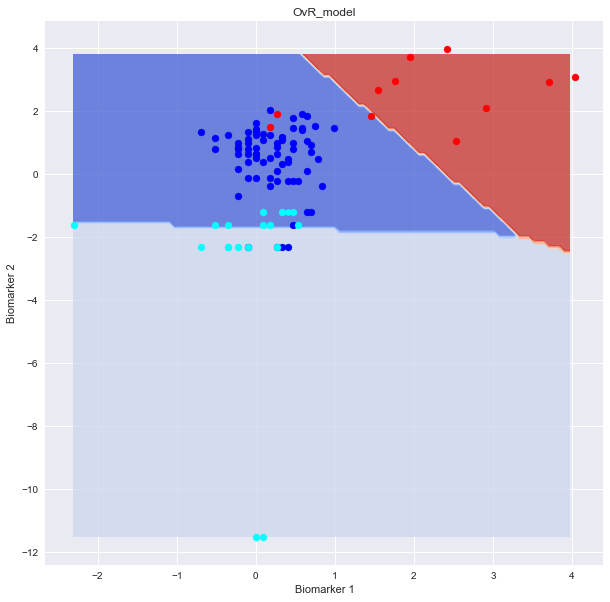

In [79]:
#Visualize the decision boundary of Multinomial logistic regression model
fig,ax=plt.subplots(figsize=(10,10))
plot_decision_boundary(data_train_x.values, data_train_y.values, OvR_model, 'OvR_model', ax, poly_degree=None)

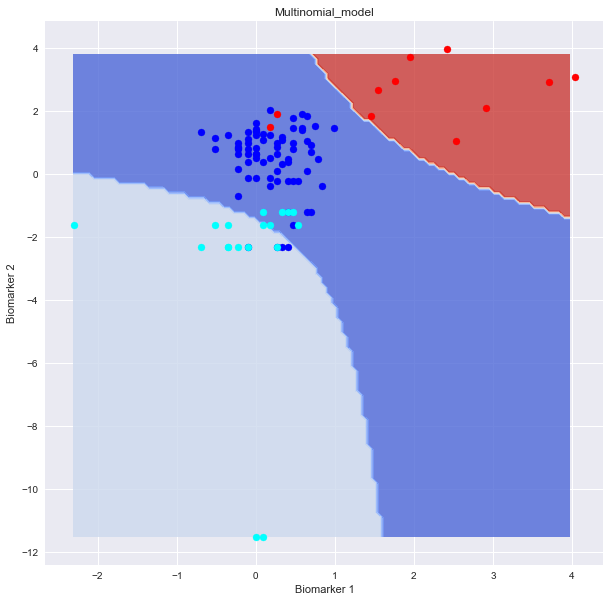

In [80]:
#Visualize the decision boundary of Multinomial logistic regression model
fig,ax=plt.subplots(figsize=(10,10))
plot_decision_boundary(data_x_matr, data_train_y.values, multi_logist, 'Multinomial_model', ax, poly_degree=2)

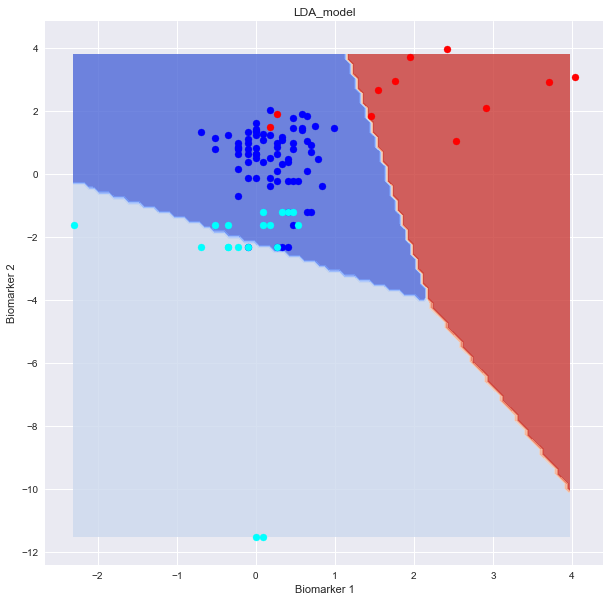

In [81]:
#Visualize the decision boundary of LDA model
fig,ax=plt.subplots(figsize=(10,10))
plot_decision_boundary(data_train_x.values, data_train_y.values, model_lda, 'LDA_model', ax, poly_degree=None)

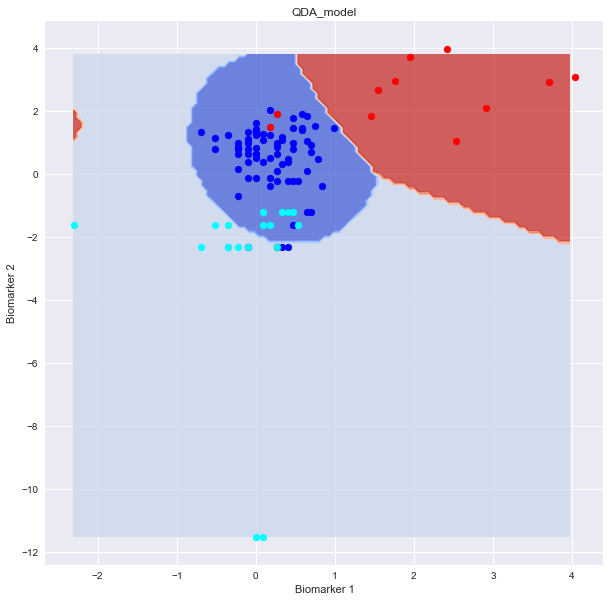

In [82]:
#Visualize the decision boundary of QDA model
fig,ax=plt.subplots(figsize=(10,10))
plot_decision_boundary(data_train_x.values, data_train_y.values, model_qda, 'QDA_model', ax, poly_degree=None)

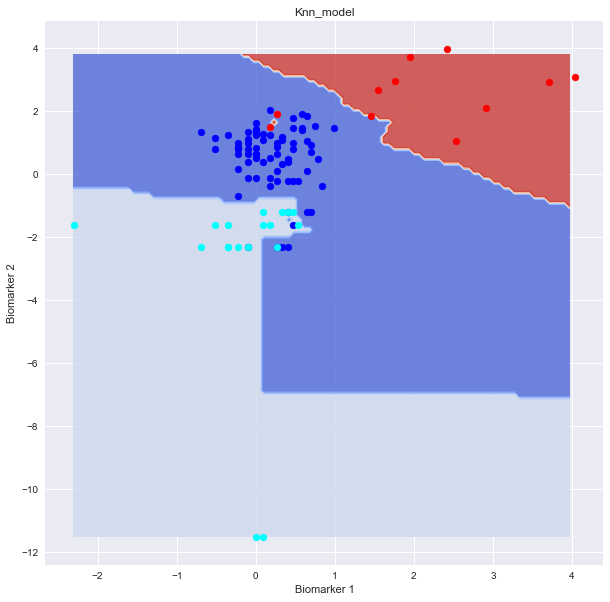

In [83]:
#Visualize the decision boundary of Knn model
fig,ax=plt.subplots(figsize=(10,10))
plot_decision_boundary(data_train_x.values, data_train_y.values, optimal_knn, 'Knn_model', ax, poly_degree=None)

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
Your answer here:

**When introducing quadratic terms into the model, the decision boundaries of the OvR and multinomial logistic regression models came out very similar. But multinomial logistic regression model has better decision boundary than OvR without quadratic terms. Compare to linear logistic regression model, the descion boundary of LDA works better. Quadratic logistic regression works better than QDA.**

---

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---
Your answer here:

**If the boundary of the classes are not linear, than QDA will be more general. In the plots I generated, QDA is more powerful to to classify the different classes.**

---